In [10]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

#function for extending our data of values from previous timestamps
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j-1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

columns=['value']
df_full = pd.DataFrame(columns = columns)
df_full_with_anomalies = pd.DataFrame(columns = ['value', 'timestamp', 'is_anomaly'])

file_path = './A1Benchmark/'

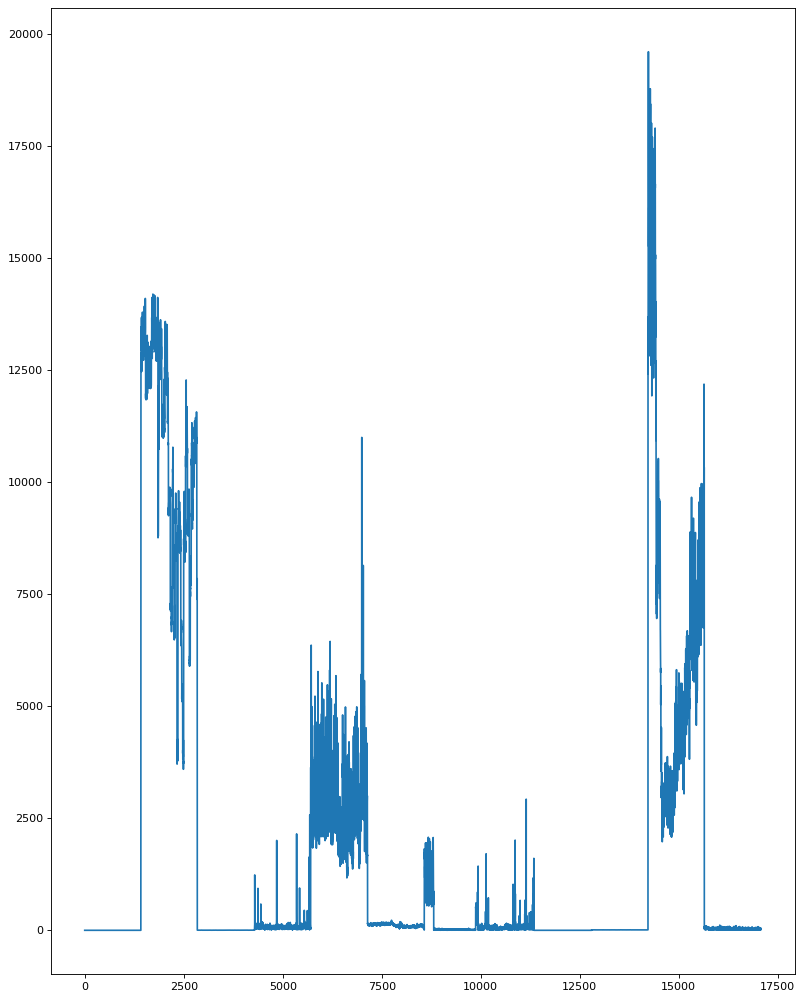

In [11]:
for i in range(1,13):
    #reading csv
    name = file_path+"real_"+str(i)+'.csv'
    df = pd.read_csv(name, encoding = "ISO-8859-1", header=0)
    df = df.iloc[::-1]
    df.columns = ['timestamp', 'value', 'is_anomaly']
    df_full_with_anomalies = pd.concat([df_full_with_anomalies, df.reset_index()], sort=True, axis=0)
    #delete anomalies from dataset
    df_no_anomalies = df[df.is_anomaly != 1]
    df_no_anomalies = df_no_anomalies.iloc[::-1]
    
    #smoothing signal
    rolling = df_no_anomalies.value.rolling(window=1)
    df_no_anomalies['value'] = rolling.mean()
    
    #droping unused columns
    df_no_anomalies.drop(columns = ["is_anomaly", "timestamp"], inplace=True)
    
    #deleting null values
    df_no_anomalies = df_no_anomalies[df_no_anomalies.value.notna()]
    
    #merging files
    df_full = pd.concat([df_full, df_no_anomalies.reset_index()], sort=True, axis=0)
    
df_full = df_full.drop(columns=['index'])
#data normalization
# df_full = (df_full - df_full.mean()) / (df_full.max() - df_full.min())
figure(num=None, figsize=(12,16), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_full.reset_index().value)

In [12]:
timesteps = 5
X, y = temporalize(X = np.array(df_full), y = np.zeros(len(df_full)), lookback = timesteps)

n_features = 1
X = np.array(X)
X = X.reshape(X.shape[0], timesteps)
Y = X[:, 0]

x_train = X[:10000, :]
x_train = x_train.reshape(x_train.shape[0],timesteps, 1)

x_test = X[10000:15000, :]
x_test = x_test.reshape(x_test.shape[0],timesteps, 1)


x_train.shape,x_test.shape, 

((10000, 5, 1), (5000, 5, 1))

In [17]:
print("Input shape: ",x_train.shape)
print("")
print(x_train)

Input shape:  (10000, 5, 1)

[[[0.00000000e+00]
  [9.17579645e-02]
  [1.72296752e-01]
  [2.26219354e-01]
  [1.76357985e-01]]

 [[9.17579645e-02]
  [1.72296752e-01]
  [2.26219354e-01]
  [1.76357985e-01]
  [9.04912455e-02]]

 [[1.72296752e-01]
  [2.26219354e-01]
  [1.76357985e-01]
  [9.04912455e-02]
  [8.46099407e-02]]

 ...

 [[1.03000000e+02]
  [5.90000000e+01]
  [6.10000000e+01]
  [7.50000000e+01]
  [1.01000000e+02]]

 [[5.90000000e+01]
  [6.10000000e+01]
  [7.50000000e+01]
  [1.01000000e+02]
  [2.70000000e+01]]

 [[6.10000000e+01]
  [7.50000000e+01]
  [1.01000000e+02]
  [2.70000000e+01]
  [2.30000000e+01]]]


In [4]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 64)             33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 128)            98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
_________________________________________________________________


In [5]:
y_train = x_train
x_train = np.delete(x_train, 0, axis=0)
y_train = np.delete(y_train, y_train.shape[0]-1, axis=0)

In [6]:
lstm_model = model.fit(x_train, y_train , epochs=100, batch_size=5, verbose=0)
# model.load_weights('./model_15-03-2020_21_18_12.h5')

In [7]:
# fit and save the model
import datetime
d = datetime.datetime.today()
model_name = "model_"+d.strftime('%d-%m-%Y_%H_%M_%S')+".h5"
weights_name = "weights_"+d.strftime('%d-%m-%Y_%H_%M_%S')+".h5"

model.save_weights("./weights/"+weights_name)

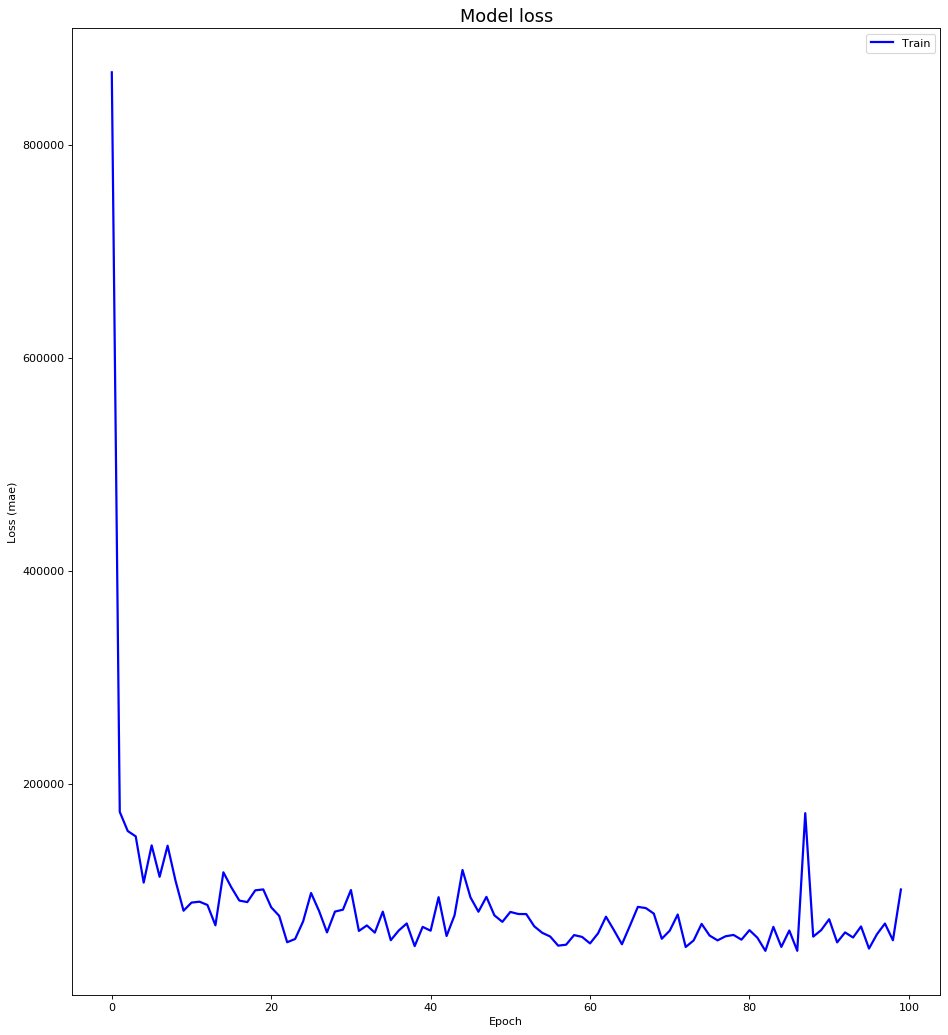

In [8]:
history = lstm_model.history
fig,ax = plt.subplots(figsize=(14,16), dpi=80)
ax.plot(history['loss'], 'b', label="Train", linewidth=2)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.set_title('Model loss', fontsize =16)
ax.legend(loc='upper right')
plt.show()

In [9]:
# demonstrate reconstruction
y_test = x_test
y_test = np.delete(y_test, y_test.shape[0]-1, axis=0)
x_test = np.delete(x_test, 0, axis=0)
yhat = model.predict(x_test, verbose=0)
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1]),1)[0::5]
yhat = yhat.reshape((yhat.shape[0]*yhat.shape[1]),1)[0::5]


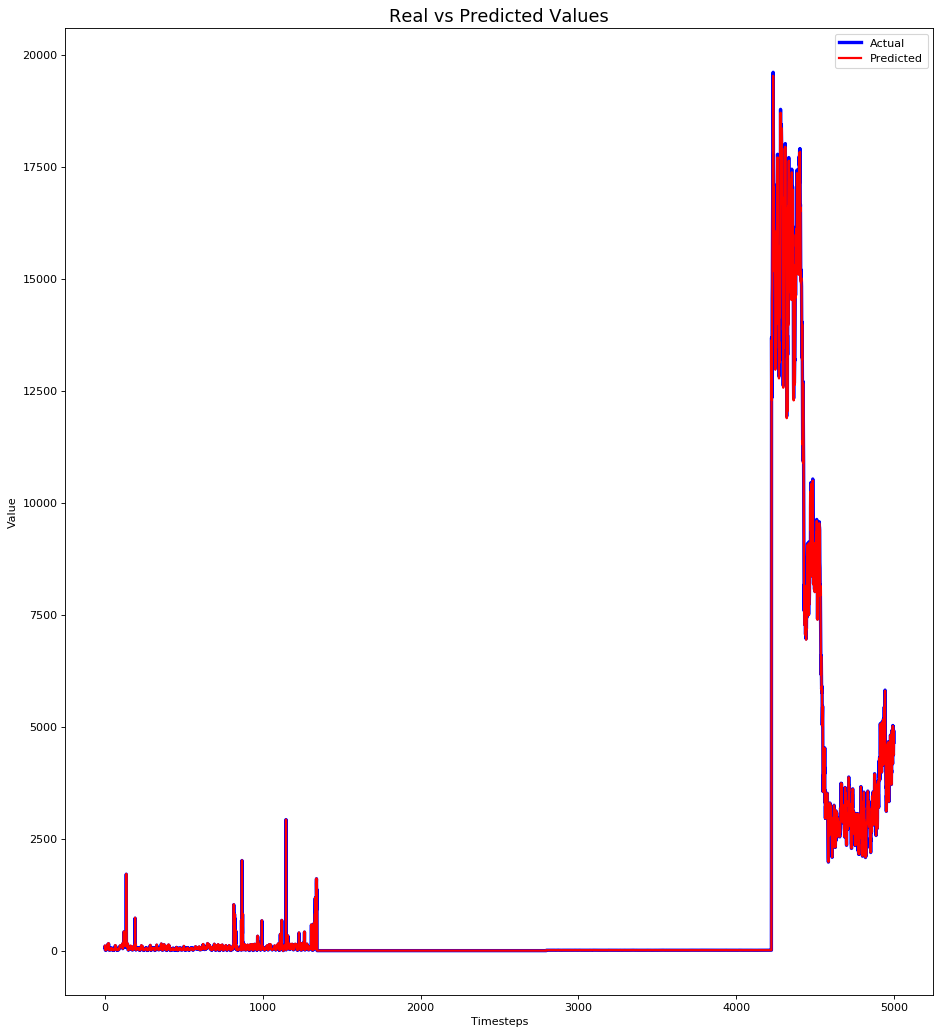

In [10]:
fig,ax = plt.subplots(figsize=(14,16), dpi=80)
ax.plot(y_test, 'b', label="Actual", linewidth=3)
ax.plot(yhat, 'r', label="Predicted", linewidth=2)
ax.set_ylabel('Value')
ax.set_xlabel('Timesteps')
ax.set_title('Real vs Predicted Values', fontsize =16)
ax.legend(loc='upper right')
plt.show()

In [20]:
df_full_with_anomalies[df_full_with_anomalies.is_anomaly ==1]
data_to_predict = np.array(df_full_with_anomalies['value'])
df_pred = df_full_with_anomalies.drop(columns=['timestamp', 'is_anomaly', 'index'])
X_with_anomalies, y = temporalize(X = np.array(df_pred), y = np.zeros(len(df_full_with_anomalies)), lookback = timesteps)

n_features = 1
X_with_anomalies = np.array(X_with_anomalies)
X_with_anomalies = X_with_anomalies.reshape(X_with_anomalies.shape[0], timesteps,1)

df_full_with_anomalies_predictions = model.predict(X_with_anomalies)

In [21]:
df_values = X_with_anomalies.reshape((X_with_anomalies.shape[0]*X_with_anomalies.shape[1]),1)[0::5]
df_predictions = df_full_with_anomalies_predictions.reshape((df_full_with_anomalies_predictions.shape[0]*df_full_with_anomalies_predictions.shape[1]),1)[0::5]

In [22]:
df_is_anomaly = df_full_with_anomalies.drop(columns=['timestamp', 'value', 'index'])
X_is_anomaly, y = temporalize(X = np.array(df_is_anomaly), y = np.zeros(len(df_is_anomaly)), lookback = timesteps)
X_is_anomaly = np.array(X_is_anomaly)
X_is_anomaly = X_is_anomaly.reshape(X_is_anomaly.shape[0], timesteps,1)
X_is_anomaly = X_is_anomaly.reshape((X_is_anomaly.shape[0]*X_is_anomaly.shape[1]),1)[0::5]

In [23]:
final_df = pd.DataFrame()
final_df['value'] = df_values.reshape(df_values.shape[0])
final_df['prediction'] = df_predictions.reshape(df_predictions.shape[0])
final_df['is_anomaly'] = X_is_anomaly.reshape(X_is_anomaly.shape[0])
final_df['abs_error'] = np.abs(df_values-df_predictions)
final_df[final_df['is_anomaly'] == 0].abs_error.describe(), \
final_df[final_df['is_anomaly'] == 1].abs_error.describe()

(count    17074.000000
 mean         8.388133
 std         12.023108
 min          0.001953
 25%          1.158237
 50%          3.813097
 75%         12.004295
 max         79.285156
 Name: abs_error, dtype: float64, count     162.000000
 mean       94.335019
 std       244.728364
 min         0.020522
 25%         1.432127
 50%         9.174119
 75%        13.502563
 max      1414.750000
 Name: abs_error, dtype: float64)

In [24]:
final_df['is_anomaly_prediction'] = final_df['abs_error'].apply(lambda x: 0 if np.abs(final_df['abs_error'].mean() - x) < 30 else 1)
final_df[(final_df['is_anomaly'] != final_df['is_anomaly_prediction']) & (final_df['is_anomaly'] == 1)].value.count(), \
final_df[(final_df['is_anomaly'] != final_df['is_anomaly_prediction']) & (final_df['is_anomaly'] == 0)].value.count()

(124, 841)

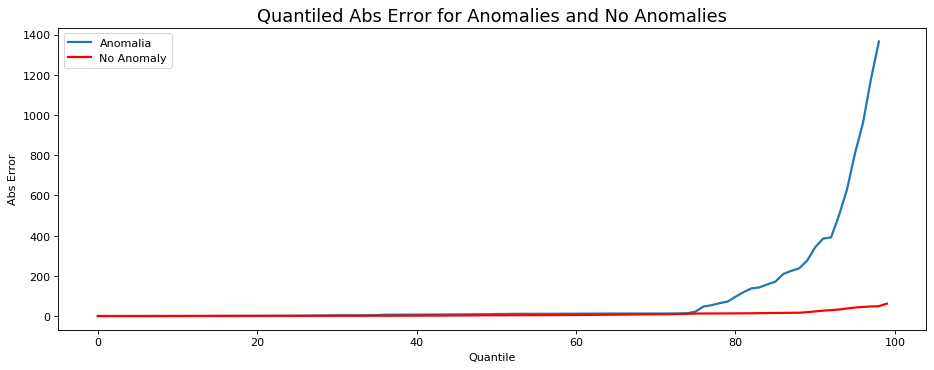

In [25]:
import sklearn.preprocessing as preproc

fig,ax = plt.subplots(figsize=(14,5), dpi=80)

anomalies = final_df[(final_df.is_anomaly == 1)]
no_anomalies = final_df[(final_df.is_anomaly == 0)]

n_of_bins = 100

anomalies['quantile'] = preproc.KBinsDiscretizer(n_bins=n_of_bins, encode='ordinal', strategy='quantile').fit_transform(anomalies.abs_error.values.reshape(-1, 1))
no_anomalies['quantile'] = preproc.KBinsDiscretizer(n_bins=n_of_bins, encode='ordinal', strategy='quantile').fit_transform(no_anomalies.abs_error.values.reshape(-1, 1))

ax.plot(anomalies.groupby(anomalies['quantile']).abs_error.mean(), label="Anomalia", linewidth=2)
ax.plot(no_anomalies.groupby(no_anomalies['quantile']).abs_error.mean(), 'r', label="No Anomaly", linewidth=2)

ax.set_ylabel('Abs Error')
ax.set_xlabel('Quantile')
ax.set_title('Quantiled Abs Error for Anomalies and No Anomalies', fontsize =16)
ax.legend(loc='upper left')
plt.show()

In [ ]:
pd.DataFrame(final_df).to_csv('/home/andy/Downloads/dataset/ydata-labeled-time-series-anomalies-v1_0/predicted_values_from_python.csv')